### 0. Install the package
You need to install the abstcal package first. If you've done this already, you can skip this step.

In [17]:
# !pip install abstcal


Looking in indexes: https://test.pypi.org/simple/
  Found existing installation: abstcal-ycui1 0.4
    Uninstalling abstcal-ycui1-0.4:
      Successfully uninstalled abstcal-ycui1-0.4


### 1. Import the package
Before you use this package, please make sure that your datasets have been pre-processed
to have the correct format. You can find more information about the required format of the datasets
on the package's GitHub page.

In [1]:
from abstcal import TLFBData, VisitData, AbstinenceCalculator

### 2. Prepare the visit dataset


In [2]:
# Import the visit dataset by specifying the path to the visit dataset
test_visit_filepath = "test_visit.csv"
# test_visit_filepath = "https://github.com/ycui1/abstcal/blob/dfac952bd85ac0303ec05c8578222684a600a4f8/test_visit.csv"
visit_data = VisitData(test_visit_filepath)

In [ ]:
# Profile the visit data
visit_data.profile_data()

# The following line profiles the visit data and saves the output to variables
# visit_summary_dataset, visit_summary_subject = visit_data.profile_data()

In [4]:
# Calculate the retention rates (optional)
visit_data.get_retention_rates()

,subject_count,retention_rate,attrition_rate,attendance_rate
visit,,,,
0,50,100.00%,0.00%,100.00%
1,46,92.00%,8.00%,90.00%
2,38,76.00%,24.00%,72.00%
3,36,72.00%,28.00%,66.00%
4,29,58.00%,42.00%,58.00%


In [7]:
# Check if any subjects have their visit dates out of the correct order
visit_data.get_out_of_order_visit_data()

,id,visit,date


In [6]:
# Remove any records with missing id, visit, or date
visit_data.drop_na_records()

0

In [5]:
# (Optional) Remove outliers if any is identified in the profiling
# Set the proper bounding dates for the dataset
floor_date = "2000-07-01"
ceil_date = "2200-07-01"
visit_data.recode_outliers(floor_date, ceil_date)

{'Number of outliers (< 07/01/2000)': 0,
 'Number of outliers (> 07/01/2200)': 0}

In [8]:
# Impute the visit dataset by filling the missing dates. By default, it will impute the
# missing dates using the most frequent interval since the reference date
visit_data.impute_data()

,imputation_code,record_count
0,RAW,193
1,IMPUTED,57


### 3. Prepare the biochemical verification measures dataset

In [9]:
# Read the CO data, by specifying the abstinence cutoff, which will be used in later processing steps
# test_co_filepath = "https://github.com/ycui1/abstcal/blob/dfac952bd85ac0303ec05c8578222684a600a4f8/test_co.csv"
test_co_filepath = "test_co.csv"
co_data = TLFBData(test_co_filepath, abst_cutoff=4)

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


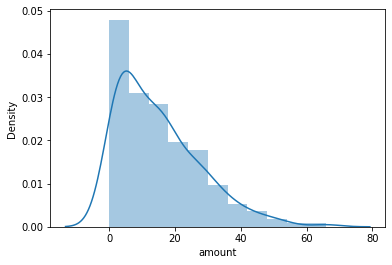

(record_count                                                               188
 subject_count                                                               50
 records_per_subject_mean                                                  3.76
 records_per_subject_range                                                1 - 5
 min_date                                                   2017-05-06 00:00:00
 max_date                                                   2019-08-18 00:00:00
 min_amount                                                                   0
 max_amount                                                                  66
 max_amount_5_records         [(1013, 11/18/2017, 66.0), (1013, 10/21/2017, ...
 min_amount_5_records         [(1005, 09/15/2017, 0.0), (1011, 02/02/2018, 0...
 missing_subject_count                                                        0
 missing_date_count                                                           0
 missing_amount_count                   

In [11]:
# Profile the CO data
co_data.profile_data()

# The following line profiles the visit data and saves the output to variables
# co_summary_dataset, co_summary_subject = co_data.profile_data()

In [12]:
# Interpolate the biochemical data by specifying the half life in days and the number
# of days for interpolation preceding the current measurement day
co_data.interpolate_biochemical_data(0.25, 1)

141

In [ ]:
# After the interpolation, you can profile the CO data again if needed
co_data.profile_data()

In [14]:
# Remove any records with missing id, date, or amount
co_data.drop_na_records()

0

In [15]:
# Check and remove any duplicates
co_data.check_duplicates()

0

### 4. Prepare the TLFB dataset

In [16]:
# Read the TLFB dataset, by default, the abstinence cutoff is zero usage
# test_tlfb_filepath = "https://github.com/ycui1/abstcal/blob/dfac952bd85ac0303ec05c8578222684a600a4f8/test_tlfb.csv"
test_tlfb_filepath = "test_tlfb.csv"
tlfb_data = TLFBData(test_tlfb_filepath)

In [ ]:
# Profile the TLFB data
tlfb_data.profile_data()

In [18]:
# Drop any records with missing id, date, or amount
tlfb_data.drop_na_records()

0

In [19]:
# Check and remove any duplicates
tlfb_data.check_duplicates()

0

In [21]:
# Recode the TLFB data to remove any outliers
tlfb_data.recode_outliers(0, 120)

{'Number of outliers (< 0)': 0, 'Number of outliers (> 120)': 0}

In [22]:
# Impute the TLFB data, an important while optional argument is the biochemical data
# It will help invalidate false negatives
tlfb_data.impute_data(biochemical_data=co_data)

,imputation_code,record_count
0,RAW,5515
1,IMPUTED,50
2,OVERRIDDEN,28


### 5. Calculate Abstinence
After you have cleaned up the TLFB and visit data, you're ready to calculate abstinence.


In [23]:
# Create the calculator by passing the TLFB and visit data
calculator = AbstinenceCalculator(tlfb_data, visit_data)

In [24]:
# Calculate the 7-day point-prevalence for visits 3 and 4
abst_pp7, lapses_pp7 = calculator.abstinence_pp([3, 4], 7)

In [25]:
# Calculate the continuous abstinence for visits 3 and 4
abst_cont, lapses_cont = calculator.abstinence_cont(1, [3, 4])

In [26]:
# Calculate the prolonged abstinence without lapses for visits 3 and 4
abst_prol, lapses_prol = calculator.abstinence_prolonged(1, [3, 4], False)

In [27]:
# Calculate the prolonged abstinence with lapses (> 5 cigs) for visits 3 and 4
abst_pros, lapses_pros = calculator.abstinence_prolonged(1, [3, 4], "5 cigs")

### 6. Merge and export data

In [ ]:
# Replace the target_filepath to where you want to save your merged datafile
abst_filepath = "merged_abst.csv"
abst_merged = calculator.merge_abst_data([abst_pp7, abst_cont, abst_prol, abst_pros], abst_filepath)

In [ ]:
lapses_filepath = "merged_lapses.csv"
lapses_merged = calculator.merge_lapse_data([lapses_pp7, lapses_cont, lapses_prol, lapses_pros], lapses_filepath)